In [2]:
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import concat
from numpy import concatenate
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import KDTree
import miceforest as mf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import Dropout
from keras.layers import LSTM

In [3]:
from data_processing import DataProcessing

p1_2020 = pd.read_csv('EndUserData2020P2.csv', encoding = 'ISO-8859-1', skiprows = [0,2])
p1_2021 = pd.read_csv('EndUserData2021P2_fix.csv', encoding = 'ISO-8859-1', skiprows = [0,2])
p1_2020_value = DataProcessing(p1_2020, p1_2021).data_process_20()
p1_2021_value = DataProcessing(p1_2020, p1_2021).data_process_21()
p1_2020_value = p1_2020_value.astype('float64')
p1_2021_value = p1_2021_value.astype('float64')
p1_2020_value = p1_2020_value.values
p1_2021_value = p1_2021_value.values

In [285]:
pd.set_option('display.max_columns',1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # move the three groups of data down for 3 2 1 rows
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
    	cols.append(df.shift(-i))
    	if i == 0:
    		names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    	else:
    		names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat df(-3),df(-2),df(-1),df)
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop the NaN columns
    if dropnan:
          	agg.dropna(inplace=True)
    return agg
    print(agg)


In [8]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(p1_2021_value)
n = 3
n_features = 8
# turn frame to supervised learning
reframed = series_to_supervised(scaled, n, 1)
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.457676,0.458929,0.000000,0.000000,0.657895,0.618953,0.087963,0.345650,0.452981,0.400957,...,0.121815,0.198174,0.456123,0.373595,0.000000,0.000000,0.657895,0.618953,0.121815,0.276530
4,0.452981,0.400957,0.000000,0.000000,0.658000,0.619052,0.121815,0.271859,0.459247,0.458929,...,0.121815,0.276530,0.457676,0.460542,0.000000,0.000000,0.657939,0.618995,0.113174,0.184318
5,0.459247,0.458929,0.000000,0.000000,0.657895,0.618953,0.121815,0.198174,0.456123,0.373595,...,0.113174,0.184318,0.454552,0.462156,0.000000,0.000000,0.658055,0.619104,0.113174,0.175134
6,0.456123,0.373595,0.000000,0.000000,0.657895,0.618953,0.121815,0.276530,0.457676,0.460542,...,0.113174,0.175134,0.457676,0.460542,0.000000,0.000000,0.658082,0.618953,0.113174,0.188937
7,0.457676,0.460542,0.000000,0.000000,0.657939,0.618995,0.113174,0.184318,0.454552,0.462156,...,0.113174,0.188937,0.454552,0.458929,0.617333,0.831395,0.657895,0.618953,0.113174,0.225832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61068,0.216298,0.186788,0.735174,0.833514,0.783479,0.000000,0.576594,0.262675,0.216298,0.173914,...,0.531600,0.276477,0.330721,0.297907,0.736194,0.834670,0.784566,0.000000,0.531600,0.281096
61069,0.216298,0.173914,0.735987,0.000000,0.000000,0.000000,0.531600,0.281096,0.289968,0.257652,...,0.531600,0.281096,0.277437,0.244759,0.735670,0.834077,0.000000,0.618953,0.531600,0.290333
61070,0.289968,0.257652,0.736466,0.834978,0.737813,0.000000,0.531600,0.276477,0.330721,0.297907,...,0.531600,0.290333,0.269600,0.236708,0.735848,0.834278,0.710526,0.000000,0.514471,0.276530
61071,0.330721,0.297907,0.736194,0.834670,0.784566,0.000000,0.531600,0.281096,0.277437,0.244759,...,0.514471,0.276530,0.307212,0.238322,0.735436,0.833811,0.783758,0.000000,0.513145,0.382492


In [9]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_20 = scaler.fit_transform(p1_2020_value)
# turn frame to supervised learning
reframed_20 = series_to_supervised(scaled_20, n, 1)
reframed_20

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.528796,0.549582,0.0000,0.000000,0.670050,0.670050,0.379997,0.204397,0.527051,0.551212,...,0.379997,0.204397,0.527051,0.547971,0.0000,0.000000,0.669563,0.669563,0.380683,0.203905
4,0.527051,0.551212,0.0000,0.000000,0.669428,0.669428,0.379997,0.197830,0.528796,0.549582,...,0.380683,0.203905,0.528796,0.551212,0.0000,0.000000,0.668963,0.668963,0.380683,0.201342
5,0.528796,0.549582,0.0000,0.000000,0.669682,0.669682,0.379997,0.204397,0.527051,0.547971,...,0.380683,0.201342,0.527051,0.546342,0.0000,0.000000,0.668508,0.668508,0.380683,0.206961
6,0.527051,0.547971,0.0000,0.000000,0.669563,0.669563,0.380683,0.203905,0.528796,0.551212,...,0.380683,0.206961,0.527051,0.547971,0.0000,0.000000,0.668173,0.668173,0.365350,0.203905
7,0.528796,0.551212,0.0000,0.000000,0.668963,0.668963,0.380683,0.201342,0.527051,0.546342,...,0.365350,0.203905,0.527051,0.549582,0.0000,0.000000,0.667838,0.667838,0.365350,0.200885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78182,0.656195,0.642266,0.7225,0.731836,0.722243,0.000000,0.651308,0.286999,0.656195,0.640655,...,0.651308,0.287455,0.656195,0.640655,0.7225,0.732531,0.722585,0.000000,0.651308,0.290019
78183,0.656195,0.640655,0.7225,0.732239,0.722448,0.000000,0.651308,0.290019,0.657941,0.643895,...,0.651308,0.290019,0.657941,0.642266,0.7225,0.732599,0.722762,0.000000,0.644610,0.290511
78184,0.657941,0.643895,0.7225,0.732693,0.722895,0.000000,0.651308,0.287455,0.656195,0.640655,...,0.644610,0.290511,0.656195,0.642266,0.7225,0.732108,0.722318,0.000000,0.644610,0.286999
78185,0.656195,0.640655,0.7225,0.732531,0.722585,0.000000,0.651308,0.290019,0.657941,0.642266,...,0.644610,0.286999,0.656195,0.640655,0.7225,0.731847,0.722060,0.000000,0.644610,0.290019


In [10]:
# 2021 data
# prepare training and validataion data set, test data set
k = 4
n_obs = n * n_features
lstm_21 = reframed.values
lstm_20 = reframed_20.values

lstm_20_len = len(lstm_20)
lstm_20_train_len = int(lstm_20_len * 0.7)

lstm_20_kfold_train_X = lstm_20[:,:n_obs]
lstm_20_kfold_train_y = lstm_20[:,-2]
num_val_samples = lstm_20_len // k

lstm_20_train = lstm_20[:lstm_20_train_len, :]
lstm_20_valid = lstm_20[lstm_20_train_len:, :]
lstm_20_train_X, lstm_20_train_y = lstm_20_train[:,:n_obs],lstm_20_train[:,-2] 
lstm_20_valid_X, lstm_20_valid_y = lstm_20_valid[:,:n_obs],lstm_20_valid[:,-2] 
lstm_21_X, lstm_21_y = lstm_21[:,:n_obs], lstm_21[:,-2]
print(lstm_20_train_X.shape, len(lstm_20_train_X))

(54728, 24) 54728


In [14]:
# design network
def fit_lstm(train_X, train_y, validation_X, validation_y, batch_size, nb_epoch, neurons):
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#     model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.add(Dropout(0.2))
    model.compile(loss='mae', optimizer='adam', metrics = ['acc'])
    # fit network
#     for i in range(nb_epoch):
    history = model.fit(train_X, train_y, epochs = nb_epoch, batch_size = batch_size, validation_data=(validation_X, validation_y), verbose=2,
                shuffle=False)
#     model.reset_states()
#         train_mae.append(evaluate(model, train_X, train_y, batch_size))
#     model.reset_states()
#         test_mae.append(evaluate(model, validation_X, validation_y, batch_size))
    
#     mae = DataFrame()
#     mae['train_loss'], mae['validation_loss'] = train_mae, test_mae
    return model, history
# , mae
#     model.reset_states()

In [15]:
def evaluate(model, validation_X, validation_y, batch_size):
    # forecast dataset
    yhat = model.predict(validation_X, batch_size=batch_size)
    validation_X = validation_X.reshape((validation_X.shape[0], n*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat,validation_X[:, -7: ]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    validation_y = validation_y.reshape((len(validation_y), 1))

    inv_y = concatenate((validation_y, validation_X[:, -7: ]), axis=1)

    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # report performance
    rmae = sqrt(mean_absolute_error(inv_y, inv_yhat))
    return rmae

In [37]:
# plot history
def plot_history(validation_X, validation_y, model):
    fig, ax = plt.subplots(figsize=(10, 5))
    # make a validation
    yhat = model.predict(validation_X)
    validation_X = validation_X.reshape((validation_X.shape[0], n*n_features))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat,validation_X[:, -7: ]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    validation_y = validation_y.reshape((len(validation_y), 1))

    inv_y = concatenate((validation_y, validation_X[:, -7: ]), axis=1)

    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    ax.plot(inv_yhat,label='prediction')
    ax.plot(inv_y,label='true')
    ax.legend()

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mape = mean_absolute_percentage_error(inv_y, inv_yhat)
    r2 = r2_score(inv_y, inv_yhat)
    print('RMSE: %.3f' % rmse)
    print('MAPE: %.3f' % mape)
    print('r2: %.3f' % r2)


In [17]:
# turn x into tensors
lstm_20_train_X = lstm_20_train_X.reshape((lstm_20_train_X.shape[0], n, n_features))
lstm_20_valid_X_reshape = lstm_20_valid_X.reshape((lstm_20_valid_X.shape[0], n, n_features))
lstm_21_X_reshape = lstm_21_X.reshape((lstm_21_X.shape[0], n, n_features))

In [28]:
n_batch = 512
n_epochs = 500
n_neurons = 1
def kfold_validation():
    train_mae, train_acc, val_mae, val_acc = list(), list(), list(), list()
    for i in range(k):
        print('processing fold #',i)
        val_data = lstm_20_kfold_train_X[i*num_val_samples : (i+1) * num_val_samples]
        val_data_reshape = val_data.reshape((val_data.shape[0], n, n_features))

        val_targets = lstm_20_kfold_train_y[i*num_val_samples : (i+1) * num_val_samples]

        partial_train_data = np.concatenate([lstm_20_kfold_train_X[:i * num_val_samples],lstm_20_kfold_train_X[(i+1) * num_val_samples:]], axis = 0)
        partial_train_data_reshape = partial_train_data.reshape((partial_train_data.shape[0], n, n_features))

        partial_train_targets = np.concatenate([lstm_20_kfold_train_y[:i * num_val_samples:],lstm_20_kfold_train_y[(i+1) * num_val_samples:]], axis = 0)
        model, history = fit_lstm(partial_train_data_reshape, partial_train_targets,val_data_reshape, val_targets, n_batch, n_epochs, n_neurons)


        val_mae.append(history.history['val_loss'])
        val_acc.append(history.history['val_acc'])
        train_mae.append(history.history['loss'])
        train_acc.append(history.history['acc'])
        
    average_train_mae_history = [np.mean([x[i] for x in train_mae]) for i in range(n_epochs)]
    average_val_mae_history = [np.mean([x[i] for x in val_mae]) for i in range(n_epochs)]

    average_train_acc_history = [np.mean([x[i] for x in train_acc]) for i in range(n_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in val_acc]) for i in range(n_epochs)]


    return model, average_val_mae_history, average_train_mae_history
    # The networ begins to overfit after 74 epochs so I a new network from scartch for the 74 epochs and then evaluate it on the test
    set


In [55]:
model, average_val_mae_history, average_train_mae_history = kfold_validation()

processing fold # 0
Epoch 1/500
115/115 - 6s - loss: 0.1171 - acc: 5.1161e-05 - val_loss: 0.0367 - val_acc: 1.5348e-04 - 6s/epoch - 51ms/step
Epoch 2/500
115/115 - 1s - loss: 0.0341 - acc: 5.1161e-05 - val_loss: 0.0335 - val_acc: 1.5348e-04 - 872ms/epoch - 8ms/step
Epoch 3/500
115/115 - 1s - loss: 0.0312 - acc: 5.1161e-05 - val_loss: 0.0229 - val_acc: 1.5348e-04 - 884ms/epoch - 8ms/step
Epoch 4/500
115/115 - 1s - loss: 0.0231 - acc: 5.1161e-05 - val_loss: 0.0297 - val_acc: 1.5348e-04 - 864ms/epoch - 8ms/step
Epoch 5/500
115/115 - 1s - loss: 0.0262 - acc: 5.1161e-05 - val_loss: 0.0155 - val_acc: 1.5348e-04 - 839ms/epoch - 7ms/step
Epoch 6/500
115/115 - 1s - loss: 0.0208 - acc: 5.1161e-05 - val_loss: 0.0174 - val_acc: 1.5348e-04 - 868ms/epoch - 8ms/step
Epoch 7/500
115/115 - 1s - loss: 0.0248 - acc: 5.1161e-05 - val_loss: 0.0143 - val_acc: 1.5348e-04 - 895ms/epoch - 8ms/step
Epoch 8/500
115/115 - 1s - loss: 0.0199 - acc: 5.1161e-05 - val_loss: 0.0104 - val_acc: 1.5348e-04 - 860ms/epoch -

Epoch 67/500
115/115 - 1s - loss: 0.0132 - acc: 5.1161e-05 - val_loss: 0.0071 - val_acc: 1.5348e-04 - 981ms/epoch - 9ms/step
Epoch 68/500
115/115 - 1s - loss: 0.0145 - acc: 5.1161e-05 - val_loss: 0.0123 - val_acc: 1.5348e-04 - 995ms/epoch - 9ms/step
Epoch 69/500
115/115 - 1s - loss: 0.0120 - acc: 5.1161e-05 - val_loss: 0.0087 - val_acc: 1.5348e-04 - 934ms/epoch - 8ms/step
Epoch 70/500
115/115 - 1s - loss: 0.0118 - acc: 5.1161e-05 - val_loss: 0.0071 - val_acc: 1.5348e-04 - 954ms/epoch - 8ms/step
Epoch 71/500
115/115 - 1s - loss: 0.0101 - acc: 5.1161e-05 - val_loss: 0.0100 - val_acc: 1.5348e-04 - 912ms/epoch - 8ms/step
Epoch 72/500
115/115 - 1s - loss: 0.0134 - acc: 5.1161e-05 - val_loss: 0.0106 - val_acc: 1.5348e-04 - 942ms/epoch - 8ms/step
Epoch 73/500
115/115 - 1s - loss: 0.0111 - acc: 5.1161e-05 - val_loss: 0.0066 - val_acc: 1.5348e-04 - 977ms/epoch - 8ms/step
Epoch 74/500
115/115 - 1s - loss: 0.0086 - acc: 5.1161e-05 - val_loss: 0.0078 - val_acc: 1.5348e-04 - 943ms/epoch - 8ms/step


Epoch 133/500
115/115 - 1s - loss: 0.0086 - acc: 5.1161e-05 - val_loss: 0.0060 - val_acc: 1.5348e-04 - 881ms/epoch - 8ms/step
Epoch 134/500
115/115 - 1s - loss: 0.0095 - acc: 5.1161e-05 - val_loss: 0.0069 - val_acc: 1.5348e-04 - 818ms/epoch - 7ms/step
Epoch 135/500
115/115 - 1s - loss: 0.0071 - acc: 5.1161e-05 - val_loss: 0.0093 - val_acc: 1.5348e-04 - 869ms/epoch - 8ms/step
Epoch 136/500
115/115 - 1s - loss: 0.0111 - acc: 5.1161e-05 - val_loss: 0.0059 - val_acc: 1.5348e-04 - 839ms/epoch - 7ms/step
Epoch 137/500
115/115 - 1s - loss: 0.0086 - acc: 5.1161e-05 - val_loss: 0.0056 - val_acc: 1.5348e-04 - 814ms/epoch - 7ms/step
Epoch 138/500
115/115 - 1s - loss: 0.0076 - acc: 5.1161e-05 - val_loss: 0.0067 - val_acc: 1.5348e-04 - 810ms/epoch - 7ms/step
Epoch 139/500
115/115 - 1s - loss: 0.0098 - acc: 5.1161e-05 - val_loss: 0.0059 - val_acc: 1.5348e-04 - 806ms/epoch - 7ms/step
Epoch 140/500
115/115 - 1s - loss: 0.0080 - acc: 5.1161e-05 - val_loss: 0.0070 - val_acc: 1.5348e-04 - 813ms/epoch - 7

Epoch 199/500
115/115 - 1s - loss: 0.0095 - acc: 5.1161e-05 - val_loss: 0.0071 - val_acc: 1.5348e-04 - 983ms/epoch - 9ms/step
Epoch 200/500
115/115 - 1s - loss: 0.0087 - acc: 5.1161e-05 - val_loss: 0.0088 - val_acc: 1.5348e-04 - 959ms/epoch - 8ms/step
Epoch 201/500
115/115 - 1s - loss: 0.0077 - acc: 5.1161e-05 - val_loss: 0.0045 - val_acc: 1.5348e-04 - 916ms/epoch - 8ms/step
Epoch 202/500
115/115 - 1s - loss: 0.0055 - acc: 5.1161e-05 - val_loss: 0.0047 - val_acc: 1.5348e-04 - 936ms/epoch - 8ms/step
Epoch 203/500
115/115 - 1s - loss: 0.0072 - acc: 5.1161e-05 - val_loss: 0.0075 - val_acc: 1.5348e-04 - 864ms/epoch - 8ms/step
Epoch 204/500
115/115 - 1s - loss: 0.0086 - acc: 5.1161e-05 - val_loss: 0.0048 - val_acc: 1.5348e-04 - 927ms/epoch - 8ms/step
Epoch 205/500
115/115 - 1s - loss: 0.0092 - acc: 5.1161e-05 - val_loss: 0.0089 - val_acc: 1.5348e-04 - 910ms/epoch - 8ms/step
Epoch 206/500
115/115 - 1s - loss: 0.0067 - acc: 5.1161e-05 - val_loss: 0.0047 - val_acc: 1.5348e-04 - 855ms/epoch - 7

Epoch 265/500
115/115 - 1s - loss: 0.0075 - acc: 5.1161e-05 - val_loss: 0.0046 - val_acc: 1.5348e-04 - 863ms/epoch - 8ms/step
Epoch 266/500
115/115 - 1s - loss: 0.0070 - acc: 5.1161e-05 - val_loss: 0.0043 - val_acc: 1.5348e-04 - 838ms/epoch - 7ms/step
Epoch 267/500
115/115 - 1s - loss: 0.0056 - acc: 5.1161e-05 - val_loss: 0.0056 - val_acc: 1.5348e-04 - 883ms/epoch - 8ms/step
Epoch 268/500
115/115 - 1s - loss: 0.0058 - acc: 5.1161e-05 - val_loss: 0.0084 - val_acc: 1.5348e-04 - 835ms/epoch - 7ms/step
Epoch 269/500
115/115 - 1s - loss: 0.0073 - acc: 5.1161e-05 - val_loss: 0.0046 - val_acc: 1.5348e-04 - 850ms/epoch - 7ms/step
Epoch 270/500
115/115 - 1s - loss: 0.0077 - acc: 5.1161e-05 - val_loss: 0.0055 - val_acc: 1.5348e-04 - 844ms/epoch - 7ms/step
Epoch 271/500
115/115 - 1s - loss: 0.0067 - acc: 5.1161e-05 - val_loss: 0.0057 - val_acc: 1.5348e-04 - 820ms/epoch - 7ms/step
Epoch 272/500
115/115 - 1s - loss: 0.0081 - acc: 5.1161e-05 - val_loss: 0.0096 - val_acc: 1.5348e-04 - 878ms/epoch - 8

115/115 - 1s - loss: 0.0055 - acc: 5.1161e-05 - val_loss: 0.0056 - val_acc: 1.5348e-04 - 811ms/epoch - 7ms/step
Epoch 331/500
115/115 - 1s - loss: 0.0065 - acc: 5.1161e-05 - val_loss: 0.0073 - val_acc: 1.5348e-04 - 1s/epoch - 9ms/step
Epoch 332/500
115/115 - 1s - loss: 0.0061 - acc: 5.1161e-05 - val_loss: 0.0040 - val_acc: 1.5348e-04 - 982ms/epoch - 9ms/step
Epoch 333/500
115/115 - 1s - loss: 0.0065 - acc: 5.1161e-05 - val_loss: 0.0059 - val_acc: 1.5348e-04 - 861ms/epoch - 7ms/step
Epoch 334/500
115/115 - 1s - loss: 0.0080 - acc: 5.1161e-05 - val_loss: 0.0055 - val_acc: 1.5348e-04 - 834ms/epoch - 7ms/step
Epoch 335/500
115/115 - 1s - loss: 0.0069 - acc: 5.1161e-05 - val_loss: 0.0040 - val_acc: 1.5348e-04 - 862ms/epoch - 7ms/step
Epoch 336/500
115/115 - 1s - loss: 0.0058 - acc: 5.1161e-05 - val_loss: 0.0056 - val_acc: 1.5348e-04 - 821ms/epoch - 7ms/step
Epoch 337/500
115/115 - 1s - loss: 0.0061 - acc: 5.1161e-05 - val_loss: 0.0077 - val_acc: 1.5348e-04 - 923ms/epoch - 8ms/step
Epoch 338

Epoch 396/500
115/115 - 1s - loss: 0.0075 - acc: 5.1161e-05 - val_loss: 0.0069 - val_acc: 1.5348e-04 - 834ms/epoch - 7ms/step
Epoch 397/500
115/115 - 1s - loss: 0.0072 - acc: 5.1161e-05 - val_loss: 0.0052 - val_acc: 1.5348e-04 - 846ms/epoch - 7ms/step
Epoch 398/500
115/115 - 1s - loss: 0.0069 - acc: 5.1161e-05 - val_loss: 0.0058 - val_acc: 1.5348e-04 - 829ms/epoch - 7ms/step
Epoch 399/500
115/115 - 1s - loss: 0.0073 - acc: 5.1161e-05 - val_loss: 0.0052 - val_acc: 1.5348e-04 - 832ms/epoch - 7ms/step
Epoch 400/500
115/115 - 1s - loss: 0.0055 - acc: 5.1161e-05 - val_loss: 0.0055 - val_acc: 1.5348e-04 - 789ms/epoch - 7ms/step
Epoch 401/500
115/115 - 1s - loss: 0.0072 - acc: 5.1161e-05 - val_loss: 0.0062 - val_acc: 1.5348e-04 - 805ms/epoch - 7ms/step
Epoch 402/500
115/115 - 1s - loss: 0.0064 - acc: 5.1161e-05 - val_loss: 0.0042 - val_acc: 1.5348e-04 - 840ms/epoch - 7ms/step
Epoch 403/500
115/115 - 1s - loss: 0.0050 - acc: 5.1161e-05 - val_loss: 0.0041 - val_acc: 1.5348e-04 - 837ms/epoch - 7

Epoch 462/500
115/115 - 1s - loss: 0.0063 - acc: 5.1161e-05 - val_loss: 0.0056 - val_acc: 1.5348e-04 - 889ms/epoch - 8ms/step
Epoch 463/500
115/115 - 1s - loss: 0.0089 - acc: 5.1161e-05 - val_loss: 0.0053 - val_acc: 1.5348e-04 - 1s/epoch - 9ms/step
Epoch 464/500
115/115 - 1s - loss: 0.0072 - acc: 5.1161e-05 - val_loss: 0.0087 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 465/500
115/115 - 1s - loss: 0.0066 - acc: 5.1161e-05 - val_loss: 0.0042 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 466/500
115/115 - 1s - loss: 0.0053 - acc: 5.1161e-05 - val_loss: 0.0053 - val_acc: 1.5348e-04 - 983ms/epoch - 9ms/step
Epoch 467/500
115/115 - 1s - loss: 0.0066 - acc: 5.1161e-05 - val_loss: 0.0044 - val_acc: 1.5348e-04 - 966ms/epoch - 8ms/step
Epoch 468/500
115/115 - 1s - loss: 0.0082 - acc: 5.1161e-05 - val_loss: 0.0095 - val_acc: 1.5348e-04 - 882ms/epoch - 8ms/step
Epoch 469/500
115/115 - 1s - loss: 0.0086 - acc: 5.1161e-05 - val_loss: 0.0061 - val_acc: 1.5348e-04 - 859ms/epoch - 7ms/step

Epoch 28/500
115/115 - 1s - loss: 0.0159 - acc: 5.1161e-05 - val_loss: 0.0158 - val_acc: 1.5348e-04 - 869ms/epoch - 8ms/step
Epoch 29/500
115/115 - 1s - loss: 0.0152 - acc: 5.1161e-05 - val_loss: 0.0155 - val_acc: 1.5348e-04 - 809ms/epoch - 7ms/step
Epoch 30/500
115/115 - 1s - loss: 0.0145 - acc: 5.1161e-05 - val_loss: 0.0145 - val_acc: 1.5348e-04 - 807ms/epoch - 7ms/step
Epoch 31/500
115/115 - 1s - loss: 0.0148 - acc: 5.1161e-05 - val_loss: 0.0149 - val_acc: 1.5348e-04 - 803ms/epoch - 7ms/step
Epoch 32/500
115/115 - 1s - loss: 0.0148 - acc: 5.1161e-05 - val_loss: 0.0165 - val_acc: 1.5348e-04 - 795ms/epoch - 7ms/step
Epoch 33/500
115/115 - 1s - loss: 0.0144 - acc: 5.1161e-05 - val_loss: 0.0186 - val_acc: 1.5348e-04 - 804ms/epoch - 7ms/step
Epoch 34/500
115/115 - 1s - loss: 0.0155 - acc: 5.1161e-05 - val_loss: 0.0168 - val_acc: 1.5348e-04 - 799ms/epoch - 7ms/step
Epoch 35/500
115/115 - 1s - loss: 0.0109 - acc: 5.1161e-05 - val_loss: 0.0124 - val_acc: 1.5348e-04 - 827ms/epoch - 7ms/step


Epoch 94/500
115/115 - 1s - loss: 0.0082 - acc: 5.1161e-05 - val_loss: 0.0079 - val_acc: 1.5348e-04 - 984ms/epoch - 9ms/step
Epoch 95/500
115/115 - 1s - loss: 0.0080 - acc: 5.1161e-05 - val_loss: 0.0073 - val_acc: 1.5348e-04 - 978ms/epoch - 9ms/step
Epoch 96/500
115/115 - 1s - loss: 0.0088 - acc: 5.1161e-05 - val_loss: 0.0086 - val_acc: 1.5348e-04 - 920ms/epoch - 8ms/step
Epoch 97/500
115/115 - 1s - loss: 0.0113 - acc: 5.1161e-05 - val_loss: 0.0112 - val_acc: 1.5348e-04 - 898ms/epoch - 8ms/step
Epoch 98/500
115/115 - 1s - loss: 0.0091 - acc: 5.1161e-05 - val_loss: 0.0073 - val_acc: 1.5348e-04 - 988ms/epoch - 9ms/step
Epoch 99/500
115/115 - 1s - loss: 0.0077 - acc: 5.1161e-05 - val_loss: 0.0075 - val_acc: 1.5348e-04 - 994ms/epoch - 9ms/step
Epoch 100/500
115/115 - 1s - loss: 0.0124 - acc: 5.1161e-05 - val_loss: 0.0101 - val_acc: 1.5348e-04 - 970ms/epoch - 8ms/step
Epoch 101/500
115/115 - 1s - loss: 0.0115 - acc: 5.1161e-05 - val_loss: 0.0087 - val_acc: 1.5348e-04 - 942ms/epoch - 8ms/ste

Epoch 160/500
115/115 - 1s - loss: 0.0084 - acc: 5.1161e-05 - val_loss: 0.0076 - val_acc: 1.5348e-04 - 980ms/epoch - 9ms/step
Epoch 161/500
115/115 - 1s - loss: 0.0076 - acc: 5.1161e-05 - val_loss: 0.0082 - val_acc: 1.5348e-04 - 1s/epoch - 9ms/step
Epoch 162/500
115/115 - 1s - loss: 0.0079 - acc: 5.1161e-05 - val_loss: 0.0085 - val_acc: 1.5348e-04 - 969ms/epoch - 8ms/step
Epoch 163/500
115/115 - 1s - loss: 0.0110 - acc: 5.1161e-05 - val_loss: 0.0186 - val_acc: 1.5348e-04 - 912ms/epoch - 8ms/step
Epoch 164/500
115/115 - 1s - loss: 0.0074 - acc: 5.1161e-05 - val_loss: 0.0058 - val_acc: 1.5348e-04 - 864ms/epoch - 8ms/step
Epoch 165/500
115/115 - 1s - loss: 0.0070 - acc: 5.1161e-05 - val_loss: 0.0086 - val_acc: 1.5348e-04 - 874ms/epoch - 8ms/step
Epoch 166/500
115/115 - 1s - loss: 0.0114 - acc: 5.1161e-05 - val_loss: 0.0148 - val_acc: 1.5348e-04 - 833ms/epoch - 7ms/step
Epoch 167/500
115/115 - 1s - loss: 0.0099 - acc: 5.1161e-05 - val_loss: 0.0093 - val_acc: 1.5348e-04 - 857ms/epoch - 7ms/

Epoch 226/500
115/115 - 1s - loss: 0.0072 - acc: 5.1161e-05 - val_loss: 0.0063 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 227/500
115/115 - 1s - loss: 0.0074 - acc: 5.1161e-05 - val_loss: 0.0100 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 228/500
115/115 - 1s - loss: 0.0070 - acc: 5.1161e-05 - val_loss: 0.0062 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 229/500
115/115 - 1s - loss: 0.0089 - acc: 5.1161e-05 - val_loss: 0.0116 - val_acc: 1.5348e-04 - 1s/epoch - 9ms/step
Epoch 230/500
115/115 - 1s - loss: 0.0102 - acc: 5.1161e-05 - val_loss: 0.0097 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 231/500
115/115 - 1s - loss: 0.0072 - acc: 5.1161e-05 - val_loss: 0.0052 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 232/500
115/115 - 1s - loss: 0.0085 - acc: 5.1161e-05 - val_loss: 0.0069 - val_acc: 1.5348e-04 - 1s/epoch - 9ms/step
Epoch 233/500
115/115 - 1s - loss: 0.0099 - acc: 5.1161e-05 - val_loss: 0.0129 - val_acc: 1.5348e-04 - 1s/epoch - 9ms/step
Epoch 234/5

115/115 - 1s - loss: 0.0085 - acc: 5.1161e-05 - val_loss: 0.0109 - val_acc: 1.5348e-04 - 906ms/epoch - 8ms/step
Epoch 293/500
115/115 - 1s - loss: 0.0063 - acc: 5.1161e-05 - val_loss: 0.0072 - val_acc: 1.5348e-04 - 855ms/epoch - 7ms/step
Epoch 294/500
115/115 - 1s - loss: 0.0083 - acc: 5.1161e-05 - val_loss: 0.0068 - val_acc: 1.5348e-04 - 866ms/epoch - 8ms/step
Epoch 295/500
115/115 - 1s - loss: 0.0071 - acc: 5.1161e-05 - val_loss: 0.0084 - val_acc: 1.5348e-04 - 848ms/epoch - 7ms/step
Epoch 296/500
115/115 - 1s - loss: 0.0062 - acc: 5.1161e-05 - val_loss: 0.0071 - val_acc: 1.5348e-04 - 852ms/epoch - 7ms/step
Epoch 297/500
115/115 - 1s - loss: 0.0087 - acc: 5.1161e-05 - val_loss: 0.0054 - val_acc: 1.5348e-04 - 850ms/epoch - 7ms/step
Epoch 298/500
115/115 - 1s - loss: 0.0080 - acc: 5.1161e-05 - val_loss: 0.0052 - val_acc: 1.5348e-04 - 873ms/epoch - 8ms/step
Epoch 299/500
115/115 - 1s - loss: 0.0071 - acc: 5.1161e-05 - val_loss: 0.0068 - val_acc: 1.5348e-04 - 856ms/epoch - 7ms/step
Epoch 

Epoch 358/500
115/115 - 1s - loss: 0.0060 - acc: 5.1161e-05 - val_loss: 0.0061 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 359/500
115/115 - 1s - loss: 0.0057 - acc: 5.1161e-05 - val_loss: 0.0103 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 360/500
115/115 - 1s - loss: 0.0086 - acc: 5.1161e-05 - val_loss: 0.0058 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 361/500
115/115 - 1s - loss: 0.0064 - acc: 5.1161e-05 - val_loss: 0.0061 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 362/500
115/115 - 1s - loss: 0.0057 - acc: 5.1161e-05 - val_loss: 0.0061 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 363/500
115/115 - 1s - loss: 0.0067 - acc: 5.1161e-05 - val_loss: 0.0080 - val_acc: 1.5348e-04 - 1s/epoch - 11ms/step
Epoch 364/500
115/115 - 1s - loss: 0.0065 - acc: 5.1161e-05 - val_loss: 0.0068 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 365/500
115/115 - 1s - loss: 0.0068 - acc: 5.1161e-05 - val_loss: 0.0047 - val_acc: 1.5348e-04 - 1s/epoch - 10ms/step
Epoch 36

Epoch 424/500
115/115 - 1s - loss: 0.0060 - acc: 5.1161e-05 - val_loss: 0.0052 - val_acc: 1.5348e-04 - 790ms/epoch - 7ms/step
Epoch 425/500
115/115 - 1s - loss: 0.0056 - acc: 5.1161e-05 - val_loss: 0.0050 - val_acc: 1.5348e-04 - 788ms/epoch - 7ms/step
Epoch 426/500
115/115 - 1s - loss: 0.0062 - acc: 5.1161e-05 - val_loss: 0.0051 - val_acc: 1.5348e-04 - 789ms/epoch - 7ms/step
Epoch 427/500
115/115 - 1s - loss: 0.0055 - acc: 5.1161e-05 - val_loss: 0.0068 - val_acc: 1.5348e-04 - 792ms/epoch - 7ms/step
Epoch 428/500
115/115 - 1s - loss: 0.0079 - acc: 5.1161e-05 - val_loss: 0.0057 - val_acc: 1.5348e-04 - 822ms/epoch - 7ms/step
Epoch 429/500
115/115 - 1s - loss: 0.0054 - acc: 5.1161e-05 - val_loss: 0.0048 - val_acc: 1.5348e-04 - 815ms/epoch - 7ms/step
Epoch 430/500
115/115 - 1s - loss: 0.0065 - acc: 5.1161e-05 - val_loss: 0.0061 - val_acc: 1.5348e-04 - 805ms/epoch - 7ms/step
Epoch 431/500
115/115 - 1s - loss: 0.0063 - acc: 5.1161e-05 - val_loss: 0.0074 - val_acc: 1.5348e-04 - 811ms/epoch - 7

115/115 - 1s - loss: 0.0070 - acc: 5.1161e-05 - val_loss: 0.0050 - val_acc: 1.5348e-04 - 933ms/epoch - 8ms/step
Epoch 490/500
115/115 - 1s - loss: 0.0070 - acc: 5.1161e-05 - val_loss: 0.0049 - val_acc: 1.5348e-04 - 906ms/epoch - 8ms/step
Epoch 491/500
115/115 - 1s - loss: 0.0056 - acc: 5.1161e-05 - val_loss: 0.0058 - val_acc: 1.5348e-04 - 861ms/epoch - 7ms/step
Epoch 492/500
115/115 - 1s - loss: 0.0064 - acc: 5.1161e-05 - val_loss: 0.0075 - val_acc: 1.5348e-04 - 914ms/epoch - 8ms/step
Epoch 493/500
115/115 - 1s - loss: 0.0064 - acc: 5.1161e-05 - val_loss: 0.0058 - val_acc: 1.5348e-04 - 862ms/epoch - 7ms/step
Epoch 494/500
115/115 - 1s - loss: 0.0067 - acc: 5.1161e-05 - val_loss: 0.0059 - val_acc: 1.5348e-04 - 792ms/epoch - 7ms/step
Epoch 495/500
115/115 - 1s - loss: 0.0061 - acc: 5.1161e-05 - val_loss: 0.0070 - val_acc: 1.5348e-04 - 799ms/epoch - 7ms/step
Epoch 496/500
115/115 - 1s - loss: 0.0062 - acc: 5.1161e-05 - val_loss: 0.0058 - val_acc: 1.5348e-04 - 785ms/epoch - 7ms/step
Epoch 

Epoch 55/500
115/115 - 1s - loss: 0.0118 - acc: 1.0232e-04 - val_loss: 0.0225 - val_acc: 0.0000e+00 - 787ms/epoch - 7ms/step
Epoch 56/500
115/115 - 1s - loss: 0.0137 - acc: 1.0232e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00 - 776ms/epoch - 7ms/step
Epoch 57/500
115/115 - 1s - loss: 0.0130 - acc: 1.0232e-04 - val_loss: 0.0176 - val_acc: 0.0000e+00 - 831ms/epoch - 7ms/step
Epoch 58/500
115/115 - 1s - loss: 0.0111 - acc: 1.0232e-04 - val_loss: 0.0177 - val_acc: 0.0000e+00 - 792ms/epoch - 7ms/step
Epoch 59/500
115/115 - 1s - loss: 0.0115 - acc: 1.0232e-04 - val_loss: 0.0218 - val_acc: 0.0000e+00 - 785ms/epoch - 7ms/step
Epoch 60/500
115/115 - 1s - loss: 0.0123 - acc: 1.0232e-04 - val_loss: 0.0139 - val_acc: 0.0000e+00 - 790ms/epoch - 7ms/step
Epoch 61/500
115/115 - 1s - loss: 0.0148 - acc: 1.0232e-04 - val_loss: 0.0212 - val_acc: 0.0000e+00 - 795ms/epoch - 7ms/step
Epoch 62/500
115/115 - 1s - loss: 0.0127 - acc: 1.0232e-04 - val_loss: 0.0149 - val_acc: 0.0000e+00 - 804ms/epoch - 7ms/step


Epoch 121/500
115/115 - 1s - loss: 0.0091 - acc: 1.0232e-04 - val_loss: 0.0103 - val_acc: 0.0000e+00 - 799ms/epoch - 7ms/step
Epoch 122/500
115/115 - 1s - loss: 0.0088 - acc: 1.0232e-04 - val_loss: 0.0191 - val_acc: 0.0000e+00 - 788ms/epoch - 7ms/step
Epoch 123/500
115/115 - 1s - loss: 0.0113 - acc: 1.0232e-04 - val_loss: 0.0097 - val_acc: 0.0000e+00 - 844ms/epoch - 7ms/step
Epoch 124/500
115/115 - 1s - loss: 0.0112 - acc: 1.0232e-04 - val_loss: 0.0110 - val_acc: 0.0000e+00 - 801ms/epoch - 7ms/step
Epoch 125/500
115/115 - 1s - loss: 0.0090 - acc: 1.0232e-04 - val_loss: 0.0091 - val_acc: 0.0000e+00 - 801ms/epoch - 7ms/step
Epoch 126/500
115/115 - 1s - loss: 0.0084 - acc: 1.0232e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00 - 800ms/epoch - 7ms/step
Epoch 127/500
115/115 - 1s - loss: 0.0090 - acc: 1.0232e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00 - 790ms/epoch - 7ms/step
Epoch 128/500
115/115 - 1s - loss: 0.0101 - acc: 1.0232e-04 - val_loss: 0.0135 - val_acc: 0.0000e+00 - 786ms/epoch - 7

Epoch 187/500
115/115 - 1s - loss: 0.0091 - acc: 1.0232e-04 - val_loss: 0.0158 - val_acc: 0.0000e+00 - 804ms/epoch - 7ms/step
Epoch 188/500
115/115 - 1s - loss: 0.0079 - acc: 1.0232e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00 - 795ms/epoch - 7ms/step
Epoch 189/500
115/115 - 1s - loss: 0.0072 - acc: 1.0232e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00 - 799ms/epoch - 7ms/step
Epoch 190/500
115/115 - 1s - loss: 0.0075 - acc: 1.0232e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00 - 807ms/epoch - 7ms/step
Epoch 191/500
115/115 - 1s - loss: 0.0067 - acc: 1.0232e-04 - val_loss: 0.0084 - val_acc: 0.0000e+00 - 862ms/epoch - 7ms/step
Epoch 192/500
115/115 - 1s - loss: 0.0073 - acc: 1.0232e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00 - 899ms/epoch - 8ms/step
Epoch 193/500
115/115 - 1s - loss: 0.0083 - acc: 1.0232e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00 - 976ms/epoch - 8ms/step
Epoch 194/500
115/115 - 1s - loss: 0.0075 - acc: 1.0232e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00 - 1s/epoch - 10ms

Epoch 253/500
115/115 - 1s - loss: 0.0065 - acc: 1.0232e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00 - 881ms/epoch - 8ms/step
Epoch 254/500
115/115 - 1s - loss: 0.0084 - acc: 1.0232e-04 - val_loss: 0.0083 - val_acc: 0.0000e+00 - 873ms/epoch - 8ms/step
Epoch 255/500
115/115 - 1s - loss: 0.0075 - acc: 1.0232e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 256/500
115/115 - 1s - loss: 0.0069 - acc: 1.0232e-04 - val_loss: 0.0094 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 257/500
115/115 - 1s - loss: 0.0068 - acc: 1.0232e-04 - val_loss: 0.0071 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 258/500
115/115 - 1s - loss: 0.0073 - acc: 1.0232e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 259/500
115/115 - 1s - loss: 0.0074 - acc: 1.0232e-04 - val_loss: 0.0077 - val_acc: 0.0000e+00 - 1s/epoch - 13ms/step
Epoch 260/500
115/115 - 1s - loss: 0.0076 - acc: 1.0232e-04 - val_loss: 0.0085 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoc

Epoch 319/500
115/115 - 1s - loss: 0.0068 - acc: 1.0232e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00 - 859ms/epoch - 7ms/step
Epoch 320/500
115/115 - 1s - loss: 0.0070 - acc: 1.0232e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00 - 896ms/epoch - 8ms/step
Epoch 321/500
115/115 - 1s - loss: 0.0068 - acc: 1.0232e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00 - 902ms/epoch - 8ms/step
Epoch 322/500
115/115 - 1s - loss: 0.0074 - acc: 1.0232e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00 - 882ms/epoch - 8ms/step
Epoch 323/500
115/115 - 1s - loss: 0.0065 - acc: 1.0232e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00 - 861ms/epoch - 7ms/step
Epoch 324/500
115/115 - 1s - loss: 0.0081 - acc: 1.0232e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00 - 873ms/epoch - 8ms/step
Epoch 325/500
115/115 - 1s - loss: 0.0071 - acc: 1.0232e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00 - 848ms/epoch - 7ms/step
Epoch 326/500
115/115 - 1s - loss: 0.0083 - acc: 1.0232e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00 - 868ms/epoch - 8

115/115 - 1s - loss: 0.0064 - acc: 1.0232e-04 - val_loss: 0.0067 - val_acc: 0.0000e+00 - 800ms/epoch - 7ms/step
Epoch 385/500
115/115 - 1s - loss: 0.0060 - acc: 1.0232e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00 - 793ms/epoch - 7ms/step
Epoch 386/500
115/115 - 1s - loss: 0.0066 - acc: 1.0232e-04 - val_loss: 0.0059 - val_acc: 0.0000e+00 - 804ms/epoch - 7ms/step
Epoch 387/500
115/115 - 1s - loss: 0.0078 - acc: 1.0232e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00 - 823ms/epoch - 7ms/step
Epoch 388/500
115/115 - 1s - loss: 0.0078 - acc: 1.0232e-04 - val_loss: 0.0119 - val_acc: 0.0000e+00 - 830ms/epoch - 7ms/step
Epoch 389/500
115/115 - 1s - loss: 0.0066 - acc: 1.0232e-04 - val_loss: 0.0058 - val_acc: 0.0000e+00 - 789ms/epoch - 7ms/step
Epoch 390/500
115/115 - 1s - loss: 0.0067 - acc: 1.0232e-04 - val_loss: 0.0060 - val_acc: 0.0000e+00 - 809ms/epoch - 7ms/step
Epoch 391/500
115/115 - 1s - loss: 0.0055 - acc: 1.0232e-04 - val_loss: 0.0062 - val_acc: 0.0000e+00 - 843ms/epoch - 7ms/step
Epoch 

Epoch 450/500
115/115 - 1s - loss: 0.0060 - acc: 1.0232e-04 - val_loss: 0.0109 - val_acc: 0.0000e+00 - 818ms/epoch - 7ms/step
Epoch 451/500
115/115 - 1s - loss: 0.0070 - acc: 1.0232e-04 - val_loss: 0.0145 - val_acc: 0.0000e+00 - 807ms/epoch - 7ms/step
Epoch 452/500
115/115 - 1s - loss: 0.0062 - acc: 1.0232e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00 - 777ms/epoch - 7ms/step
Epoch 453/500
115/115 - 1s - loss: 0.0072 - acc: 1.0232e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00 - 810ms/epoch - 7ms/step
Epoch 454/500
115/115 - 1s - loss: 0.0064 - acc: 1.0232e-04 - val_loss: 0.0064 - val_acc: 0.0000e+00 - 799ms/epoch - 7ms/step
Epoch 455/500
115/115 - 1s - loss: 0.0062 - acc: 1.0232e-04 - val_loss: 0.0077 - val_acc: 0.0000e+00 - 815ms/epoch - 7ms/step
Epoch 456/500
115/115 - 1s - loss: 0.0072 - acc: 1.0232e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00 - 819ms/epoch - 7ms/step
Epoch 457/500
115/115 - 1s - loss: 0.0071 - acc: 1.0232e-04 - val_loss: 0.0110 - val_acc: 0.0000e+00 - 800ms/epoch - 7

Epoch 16/500
115/115 - 1s - loss: 0.0168 - acc: 1.0232e-04 - val_loss: 0.0287 - val_acc: 0.0000e+00 - 1s/epoch - 10ms/step
Epoch 17/500
115/115 - 1s - loss: 0.0141 - acc: 1.0232e-04 - val_loss: 0.0260 - val_acc: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 18/500
115/115 - 1s - loss: 0.0134 - acc: 1.0232e-04 - val_loss: 0.0259 - val_acc: 0.0000e+00 - 959ms/epoch - 8ms/step
Epoch 19/500
115/115 - 1s - loss: 0.0128 - acc: 1.0232e-04 - val_loss: 0.0257 - val_acc: 0.0000e+00 - 943ms/epoch - 8ms/step
Epoch 20/500
115/115 - 1s - loss: 0.0129 - acc: 1.0232e-04 - val_loss: 0.0254 - val_acc: 0.0000e+00 - 896ms/epoch - 8ms/step
Epoch 21/500
115/115 - 1s - loss: 0.0130 - acc: 1.0232e-04 - val_loss: 0.0288 - val_acc: 0.0000e+00 - 911ms/epoch - 8ms/step
Epoch 22/500
115/115 - 1s - loss: 0.0234 - acc: 1.0232e-04 - val_loss: 0.0313 - val_acc: 0.0000e+00 - 845ms/epoch - 7ms/step
Epoch 23/500
115/115 - 1s - loss: 0.0171 - acc: 1.0232e-04 - val_loss: 0.0281 - val_acc: 0.0000e+00 - 900ms/epoch - 8ms/step
Epoch

Epoch 82/500
115/115 - 1s - loss: 0.0122 - acc: 1.0232e-04 - val_loss: 0.0189 - val_acc: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 83/500
115/115 - 1s - loss: 0.0091 - acc: 1.0232e-04 - val_loss: 0.0167 - val_acc: 0.0000e+00 - 1s/epoch - 10ms/step
Epoch 84/500
115/115 - 1s - loss: 0.0109 - acc: 1.0232e-04 - val_loss: 0.0222 - val_acc: 0.0000e+00 - 1s/epoch - 10ms/step
Epoch 85/500
115/115 - 1s - loss: 0.0130 - acc: 1.0232e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00 - 965ms/epoch - 8ms/step
Epoch 86/500
115/115 - 1s - loss: 0.0098 - acc: 1.0232e-04 - val_loss: 0.0191 - val_acc: 0.0000e+00 - 963ms/epoch - 8ms/step
Epoch 87/500
115/115 - 1s - loss: 0.0101 - acc: 1.0232e-04 - val_loss: 0.0184 - val_acc: 0.0000e+00 - 953ms/epoch - 8ms/step
Epoch 88/500
115/115 - 1s - loss: 0.0098 - acc: 1.0232e-04 - val_loss: 0.0179 - val_acc: 0.0000e+00 - 929ms/epoch - 8ms/step
Epoch 89/500
115/115 - 1s - loss: 0.0101 - acc: 1.0232e-04 - val_loss: 0.0174 - val_acc: 0.0000e+00 - 934ms/epoch - 8ms/step
Epoch 9

Epoch 148/500
115/115 - 1s - loss: 0.0078 - acc: 1.0232e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00 - 857ms/epoch - 7ms/step
Epoch 149/500
115/115 - 1s - loss: 0.0100 - acc: 1.0232e-04 - val_loss: 0.0120 - val_acc: 0.0000e+00 - 839ms/epoch - 7ms/step
Epoch 150/500
115/115 - 1s - loss: 0.0067 - acc: 1.0232e-04 - val_loss: 0.0124 - val_acc: 0.0000e+00 - 999ms/epoch - 9ms/step
Epoch 151/500
115/115 - 1s - loss: 0.0083 - acc: 1.0232e-04 - val_loss: 0.0204 - val_acc: 0.0000e+00 - 1s/epoch - 10ms/step
Epoch 152/500
115/115 - 1s - loss: 0.0093 - acc: 1.0232e-04 - val_loss: 0.0128 - val_acc: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 153/500
115/115 - 1s - loss: 0.0070 - acc: 1.0232e-04 - val_loss: 0.0126 - val_acc: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 154/500
115/115 - 1s - loss: 0.0077 - acc: 1.0232e-04 - val_loss: 0.0173 - val_acc: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 155/500
115/115 - 1s - loss: 0.0117 - acc: 1.0232e-04 - val_loss: 0.0150 - val_acc: 0.0000e+00 - 891ms/epoch - 8ms/step
Epo

Epoch 214/500
115/115 - 1s - loss: 0.0066 - acc: 1.0232e-04 - val_loss: 0.0138 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 215/500
115/115 - 1s - loss: 0.0081 - acc: 1.0232e-04 - val_loss: 0.0166 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 216/500
115/115 - 1s - loss: 0.0079 - acc: 1.0232e-04 - val_loss: 0.0102 - val_acc: 0.0000e+00 - 1s/epoch - 11ms/step
Epoch 217/500
115/115 - 1s - loss: 0.0062 - acc: 1.0232e-04 - val_loss: 0.0124 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 218/500
115/115 - 1s - loss: 0.0060 - acc: 1.0232e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 219/500
115/115 - 1s - loss: 0.0065 - acc: 1.0232e-04 - val_loss: 0.0101 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 220/500
115/115 - 1s - loss: 0.0061 - acc: 1.0232e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 221/500
115/115 - 1s - loss: 0.0086 - acc: 1.0232e-04 - val_loss: 0.0141 - val_acc: 0.0000e+00 - 1s/epoch - 12ms/step
Epoch 22

Epoch 280/500
115/115 - 1s - loss: 0.0069 - acc: 1.0232e-04 - val_loss: 0.0096 - val_acc: 0.0000e+00 - 883ms/epoch - 8ms/step
Epoch 281/500
115/115 - 1s - loss: 0.0065 - acc: 1.0232e-04 - val_loss: 0.0079 - val_acc: 0.0000e+00 - 864ms/epoch - 8ms/step
Epoch 282/500
115/115 - 1s - loss: 0.0066 - acc: 1.0232e-04 - val_loss: 0.0138 - val_acc: 0.0000e+00 - 822ms/epoch - 7ms/step
Epoch 283/500
115/115 - 1s - loss: 0.0082 - acc: 1.0232e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00 - 842ms/epoch - 7ms/step
Epoch 284/500
115/115 - 1s - loss: 0.0065 - acc: 1.0232e-04 - val_loss: 0.0091 - val_acc: 0.0000e+00 - 916ms/epoch - 8ms/step
Epoch 285/500
115/115 - 1s - loss: 0.0068 - acc: 1.0232e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00 - 900ms/epoch - 8ms/step
Epoch 286/500
115/115 - 1s - loss: 0.0068 - acc: 1.0232e-04 - val_loss: 0.0092 - val_acc: 0.0000e+00 - 877ms/epoch - 8ms/step
Epoch 287/500
115/115 - 1s - loss: 0.0061 - acc: 1.0232e-04 - val_loss: 0.0102 - val_acc: 0.0000e+00 - 872ms/epoch - 8

Epoch 346/500
115/115 - 1s - loss: 0.0078 - acc: 1.0232e-04 - val_loss: 0.0077 - val_acc: 0.0000e+00 - 834ms/epoch - 7ms/step
Epoch 347/500
115/115 - 1s - loss: 0.0054 - acc: 1.0232e-04 - val_loss: 0.0091 - val_acc: 0.0000e+00 - 900ms/epoch - 8ms/step
Epoch 348/500
115/115 - 1s - loss: 0.0075 - acc: 1.0232e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00 - 912ms/epoch - 8ms/step
Epoch 349/500
115/115 - 1s - loss: 0.0056 - acc: 1.0232e-04 - val_loss: 0.0085 - val_acc: 0.0000e+00 - 931ms/epoch - 8ms/step
Epoch 350/500
115/115 - 1s - loss: 0.0060 - acc: 1.0232e-04 - val_loss: 0.0092 - val_acc: 0.0000e+00 - 905ms/epoch - 8ms/step
Epoch 351/500
115/115 - 1s - loss: 0.0075 - acc: 1.0232e-04 - val_loss: 0.0088 - val_acc: 0.0000e+00 - 944ms/epoch - 8ms/step
Epoch 352/500
115/115 - 1s - loss: 0.0064 - acc: 1.0232e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00 - 867ms/epoch - 8ms/step
Epoch 353/500
115/115 - 1s - loss: 0.0051 - acc: 1.0232e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00 - 840ms/epoch - 7

Epoch 412/500
115/115 - 1s - loss: 0.0048 - acc: 1.0232e-04 - val_loss: 0.0075 - val_acc: 0.0000e+00 - 935ms/epoch - 8ms/step
Epoch 413/500
115/115 - 1s - loss: 0.0051 - acc: 1.0232e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00 - 923ms/epoch - 8ms/step
Epoch 414/500
115/115 - 1s - loss: 0.0070 - acc: 1.0232e-04 - val_loss: 0.0149 - val_acc: 0.0000e+00 - 983ms/epoch - 9ms/step
Epoch 415/500
115/115 - 1s - loss: 0.0070 - acc: 1.0232e-04 - val_loss: 0.0077 - val_acc: 0.0000e+00 - 1s/epoch - 10ms/step
Epoch 416/500
115/115 - 1s - loss: 0.0068 - acc: 1.0232e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00 - 1s/epoch - 9ms/step
Epoch 417/500
115/115 - 1s - loss: 0.0061 - acc: 1.0232e-04 - val_loss: 0.0071 - val_acc: 0.0000e+00 - 988ms/epoch - 9ms/step
Epoch 418/500
115/115 - 1s - loss: 0.0051 - acc: 1.0232e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00 - 990ms/epoch - 9ms/step
Epoch 419/500
115/115 - 1s - loss: 0.0061 - acc: 1.0232e-04 - val_loss: 0.0077 - val_acc: 0.0000e+00 - 956ms/epoch - 8ms/st

Epoch 478/500
115/115 - 1s - loss: 0.0073 - acc: 1.0232e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00 - 866ms/epoch - 8ms/step
Epoch 479/500
115/115 - 1s - loss: 0.0055 - acc: 1.0232e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00 - 857ms/epoch - 7ms/step
Epoch 480/500
115/115 - 1s - loss: 0.0054 - acc: 1.0232e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00 - 843ms/epoch - 7ms/step
Epoch 481/500
115/115 - 1s - loss: 0.0057 - acc: 1.0232e-04 - val_loss: 0.0072 - val_acc: 0.0000e+00 - 796ms/epoch - 7ms/step
Epoch 482/500
115/115 - 1s - loss: 0.0055 - acc: 1.0232e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00 - 887ms/epoch - 8ms/step
Epoch 483/500
115/115 - 1s - loss: 0.0064 - acc: 1.0232e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00 - 913ms/epoch - 8ms/step
Epoch 484/500
115/115 - 1s - loss: 0.0064 - acc: 1.0232e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00 - 908ms/epoch - 8ms/step
Epoch 485/500
115/115 - 1s - loss: 0.0065 - acc: 1.0232e-04 - val_loss: 0.0073 - val_acc: 0.0000e+00 - 891ms/epoch - 8

<IPython.core.display.Javascript object>


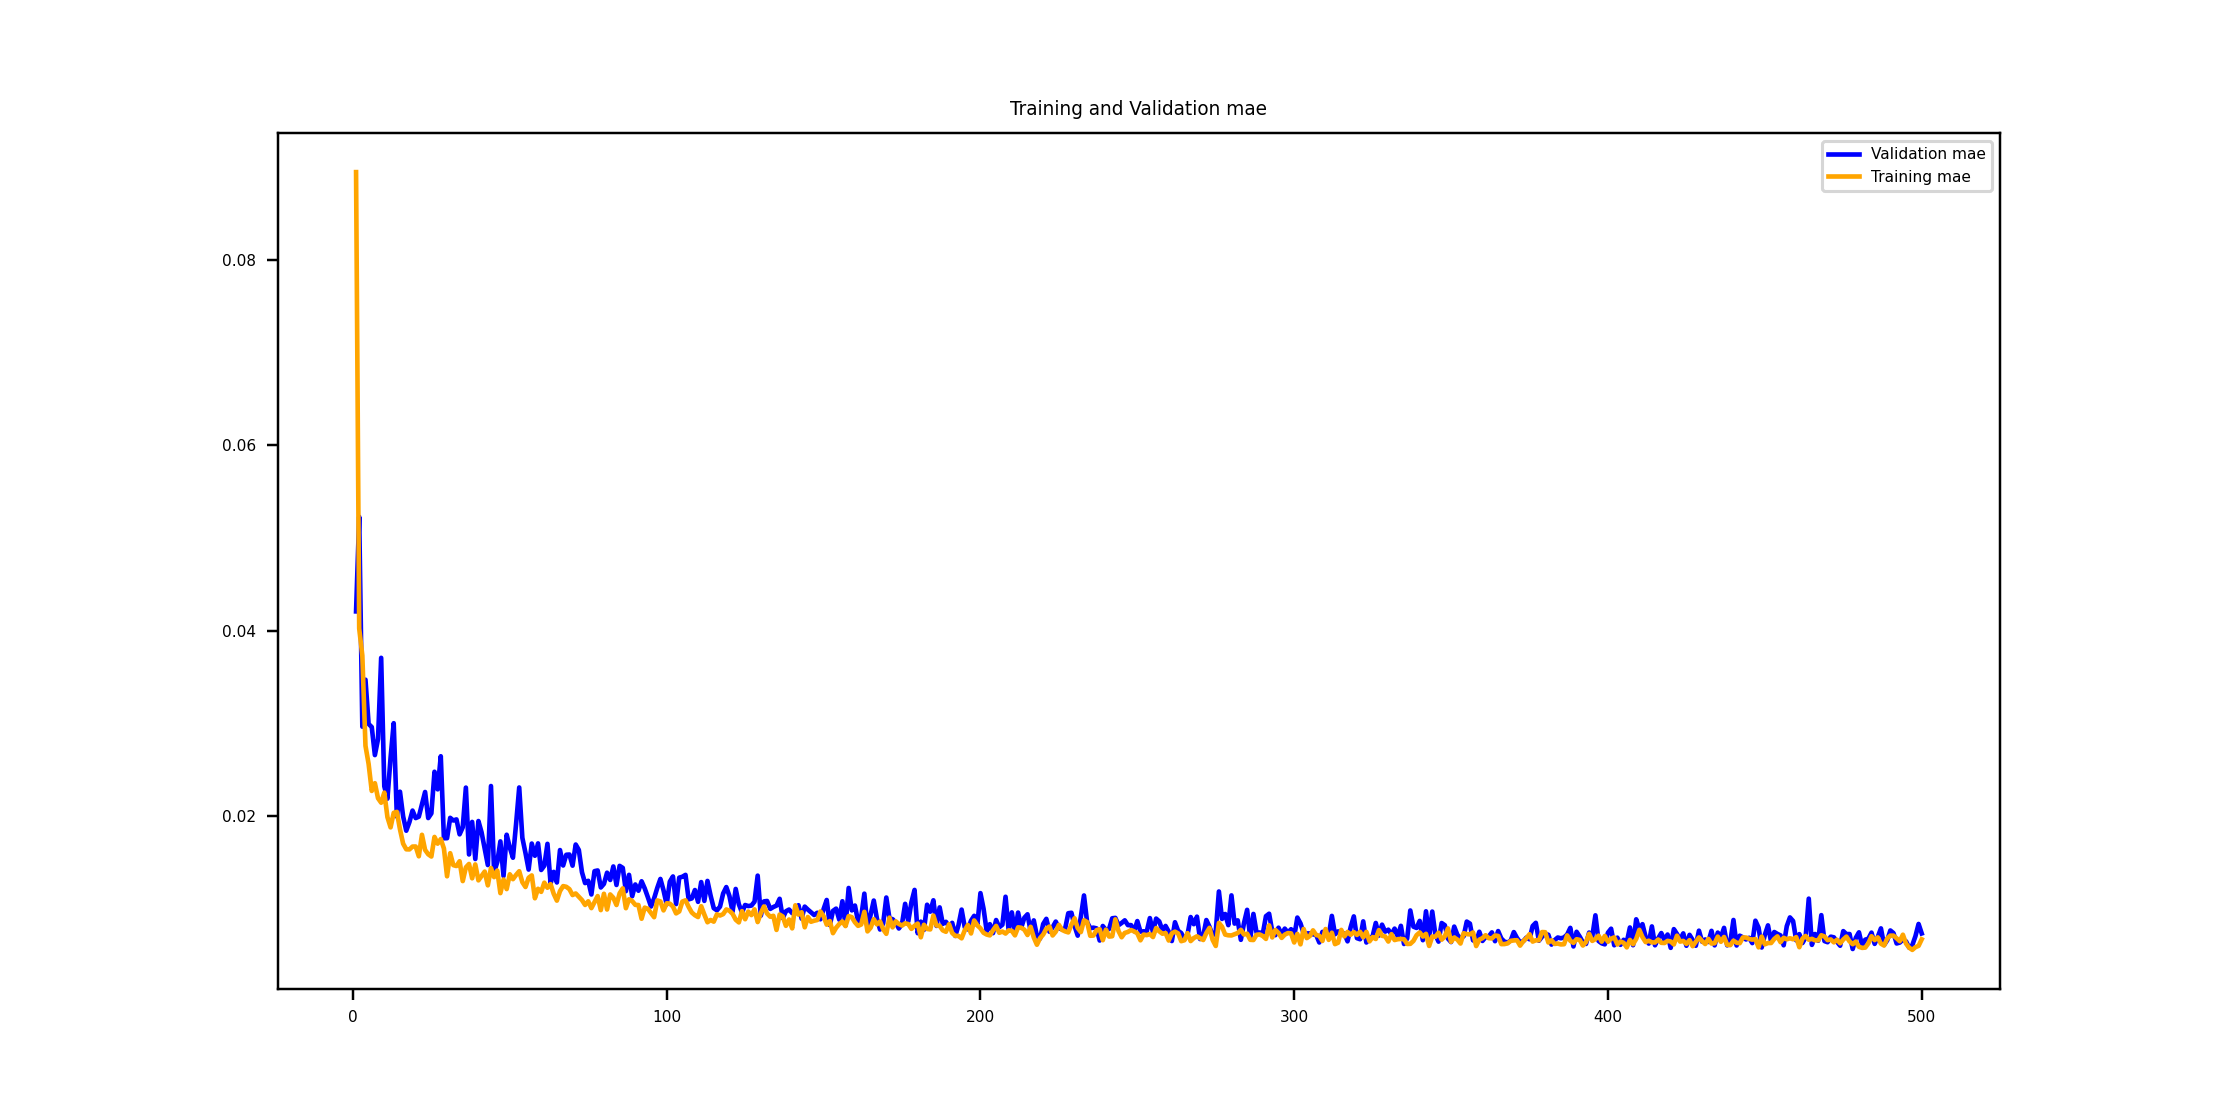

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax[0].plot(range(1, len(average_val_acc_history)+1), average_val_acc_history, color = 'blue', label = "Validation acc")
# ax[0].plot(range(1, len(average_train_acc_history)+1), average_train_acc_history, color = 'orange', label = "Training acc")
# ax[0].set_title('Training and Validation accuracy')
# ax[0].legend()

ax.plot(range(1, len(average_val_mae_history)+1), average_val_mae_history, color = 'blue', label = "Validation mae")
ax.plot(range(1, len(average_train_mae_history)+1), average_train_mae_history, color = 'orange', label = "Training mae")
ax.set_title('Training and Validation mae')
ax.legend()

In [57]:
def smooth_curve(points, factor = 0.9):
    
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

<IPython.core.display.Javascript object>


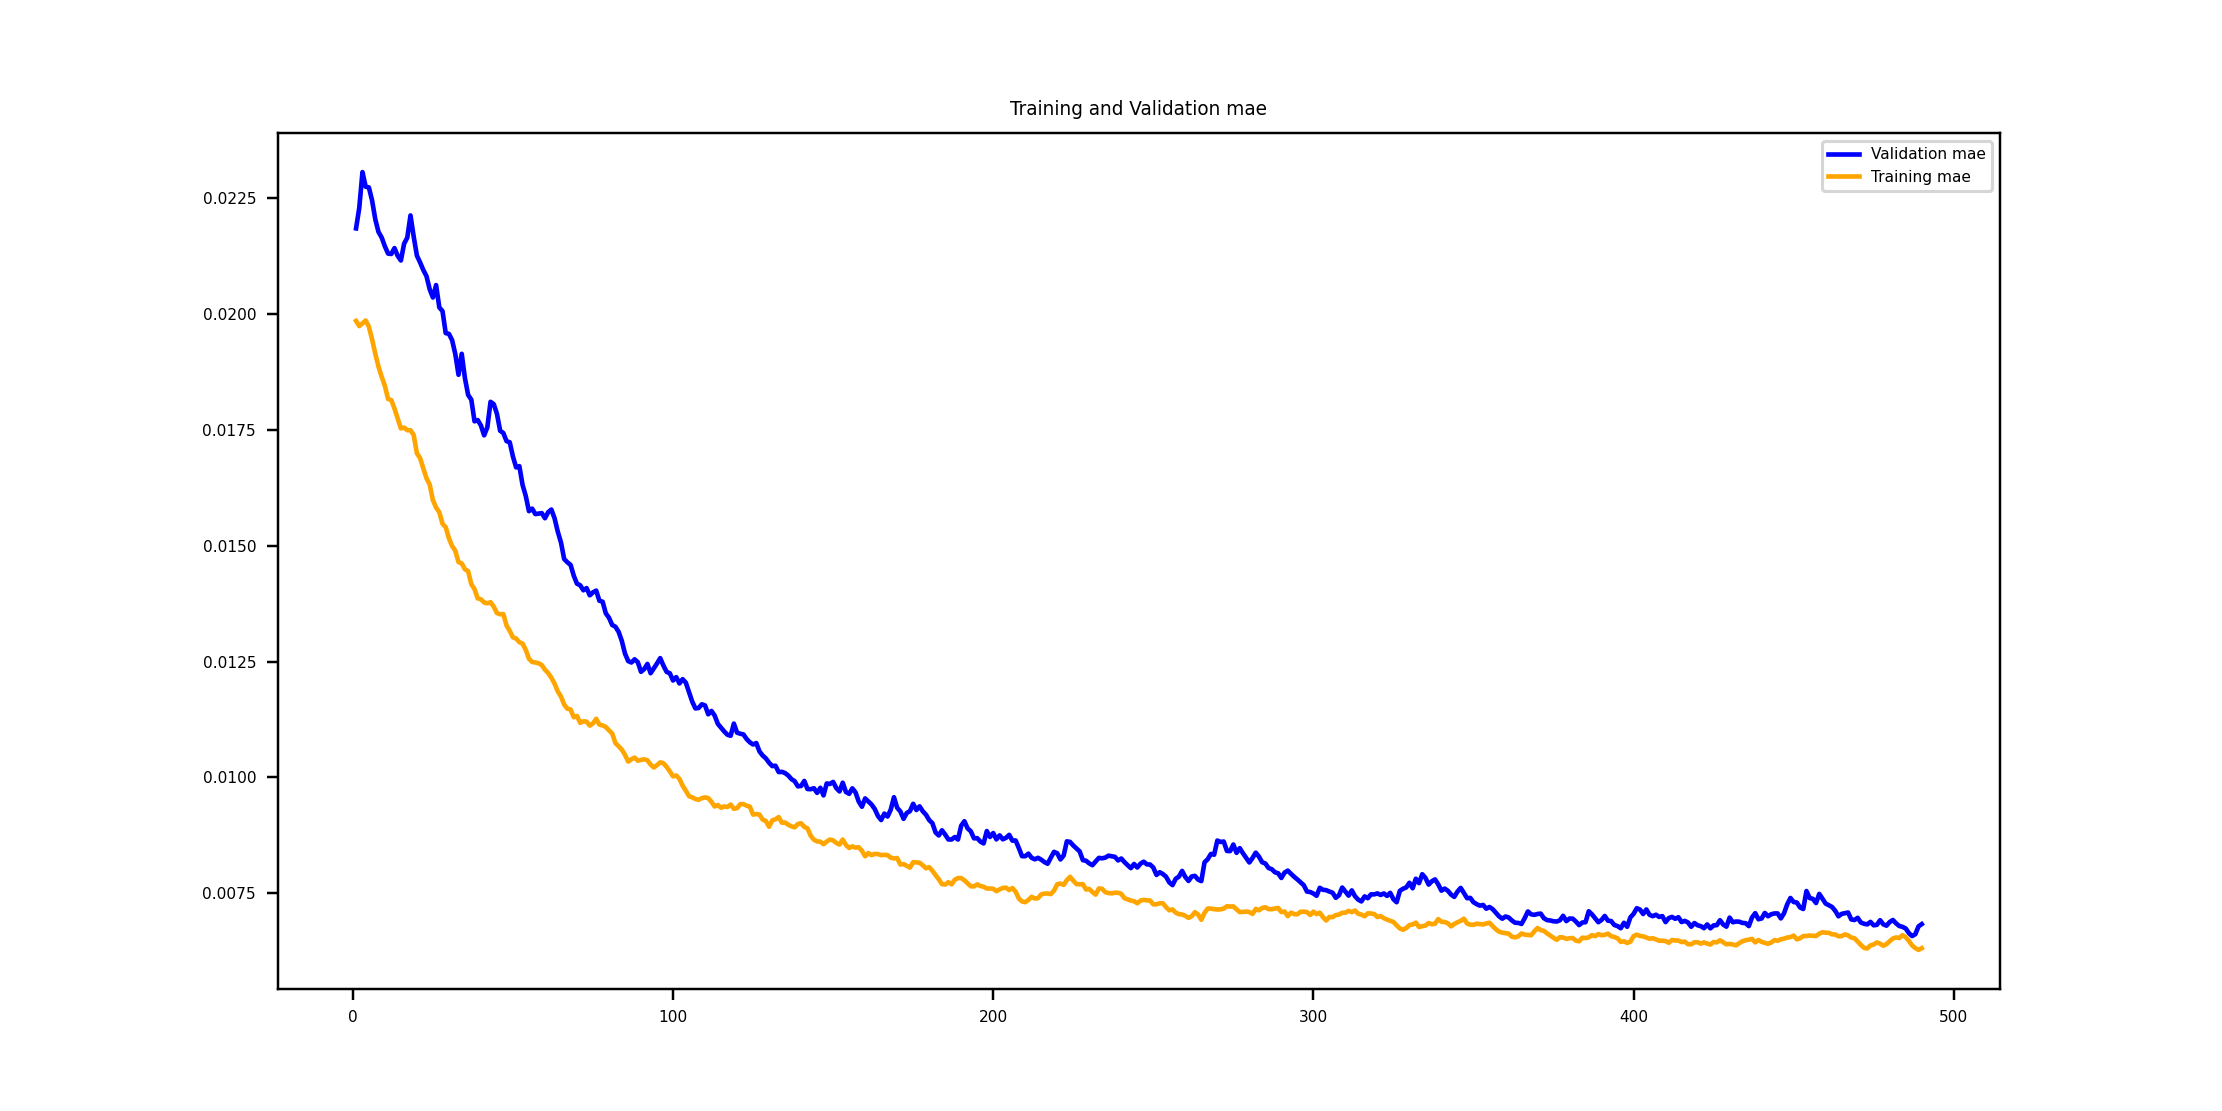

In [58]:
smooth_train_mae = smooth_curve(average_train_mae_history[10:])
smooth_val_mae = smooth_curve(average_val_mae_history[10:])

fig, ax = plt.subplots(figsize=(10, 5))
# ax[0].plot(range(1, len(average_val_acc_history)+1), average_val_acc_history, color = 'blue', label = "Validation acc")
# ax[0].plot(range(1, len(average_train_acc_history)+1), average_train_acc_history, color = 'orange', label = "Training acc")
# ax[0].set_title('Training and Validation accuracy')
# ax[0].legend()

ax.plot(range(1, len(smooth_val_mae)+1), smooth_val_mae, color = 'blue', label = "Validation mae")
ax.plot(range(1, len(smooth_train_mae)+1), smooth_train_mae, color = 'orange', label = "Training mae")
ax.set_title('Training and Validation mae')
ax.legend()

<IPython.core.display.Javascript object>


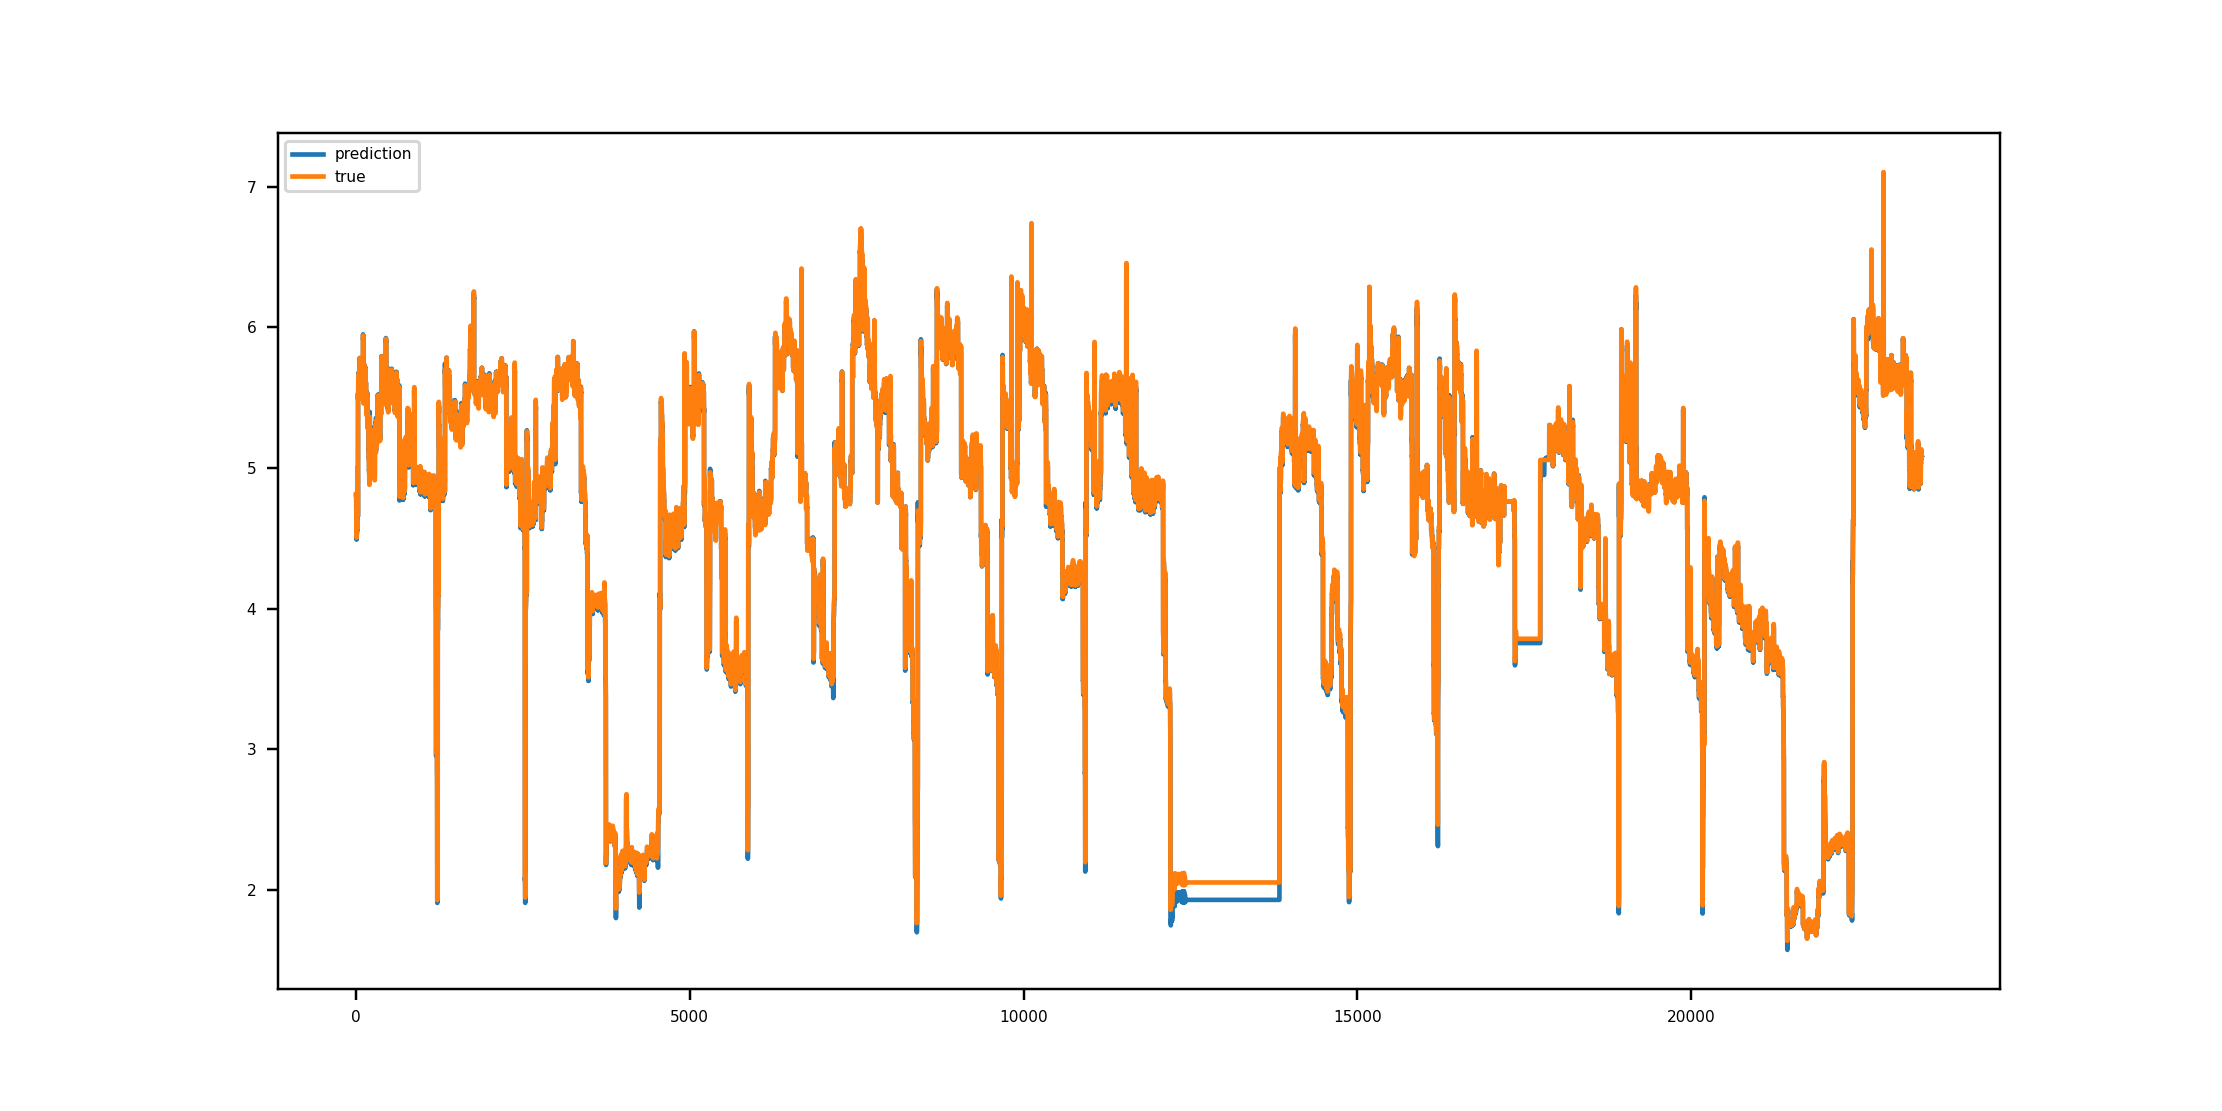

733/733 [==============================] - 1s 1ms/step
RMSE: 0.100
MAPE: 0.012
r2: 0.993


In [59]:
plot_history(lstm_20_valid_X_reshape, lstm_20_valid_y, model)


In [54]:
lstm_20_valid_y

array([0.5957931 , 0.5957931 , 0.5957931 , ..., 0.64460959, 0.64460959,
       0.64024583])

In [147]:
# plot history
def plot_history_acc(validation_X, validation_y, model):
    # make a validation
    yhat = model.predict(validation_X)
    validation_X = validation_X.reshape((validation_X.shape[0], n*n_features))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat,validation_X[:, -7: ]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    validation_y = validation_y.reshape((len(validation_y), 1))

    inv_y = concatenate((validation_y, validation_X[:, -7: ]), axis=1)

    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    test = DataFrame()
    test['test_predict'] = inv_yhat
    test['test_true'] = inv_y
    test['acc'] = test.apply(lambda x: x['test_true'] / x['test_predict'], axis=1)
    test['acc']
    test['mape'] = abs(test['test_predict'] - test['test_true'])/test['test_true']
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(inv_yhat,label='prediction')
    ax.plot(inv_y,label='true')
    ax.legend()

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    mape = mean_absolute_percentage_error(inv_y, inv_yhat)
    r2 = r2_score(inv_y, inv_yhat)
    print('RMSE: %.3f' % rmse)
    print('MAPE: %.3f' % mape)
    print('r2: %.3f' % r2)
    return test


1909/1909 [==============================] - 3s 1ms/step


<IPython.core.display.Javascript object>


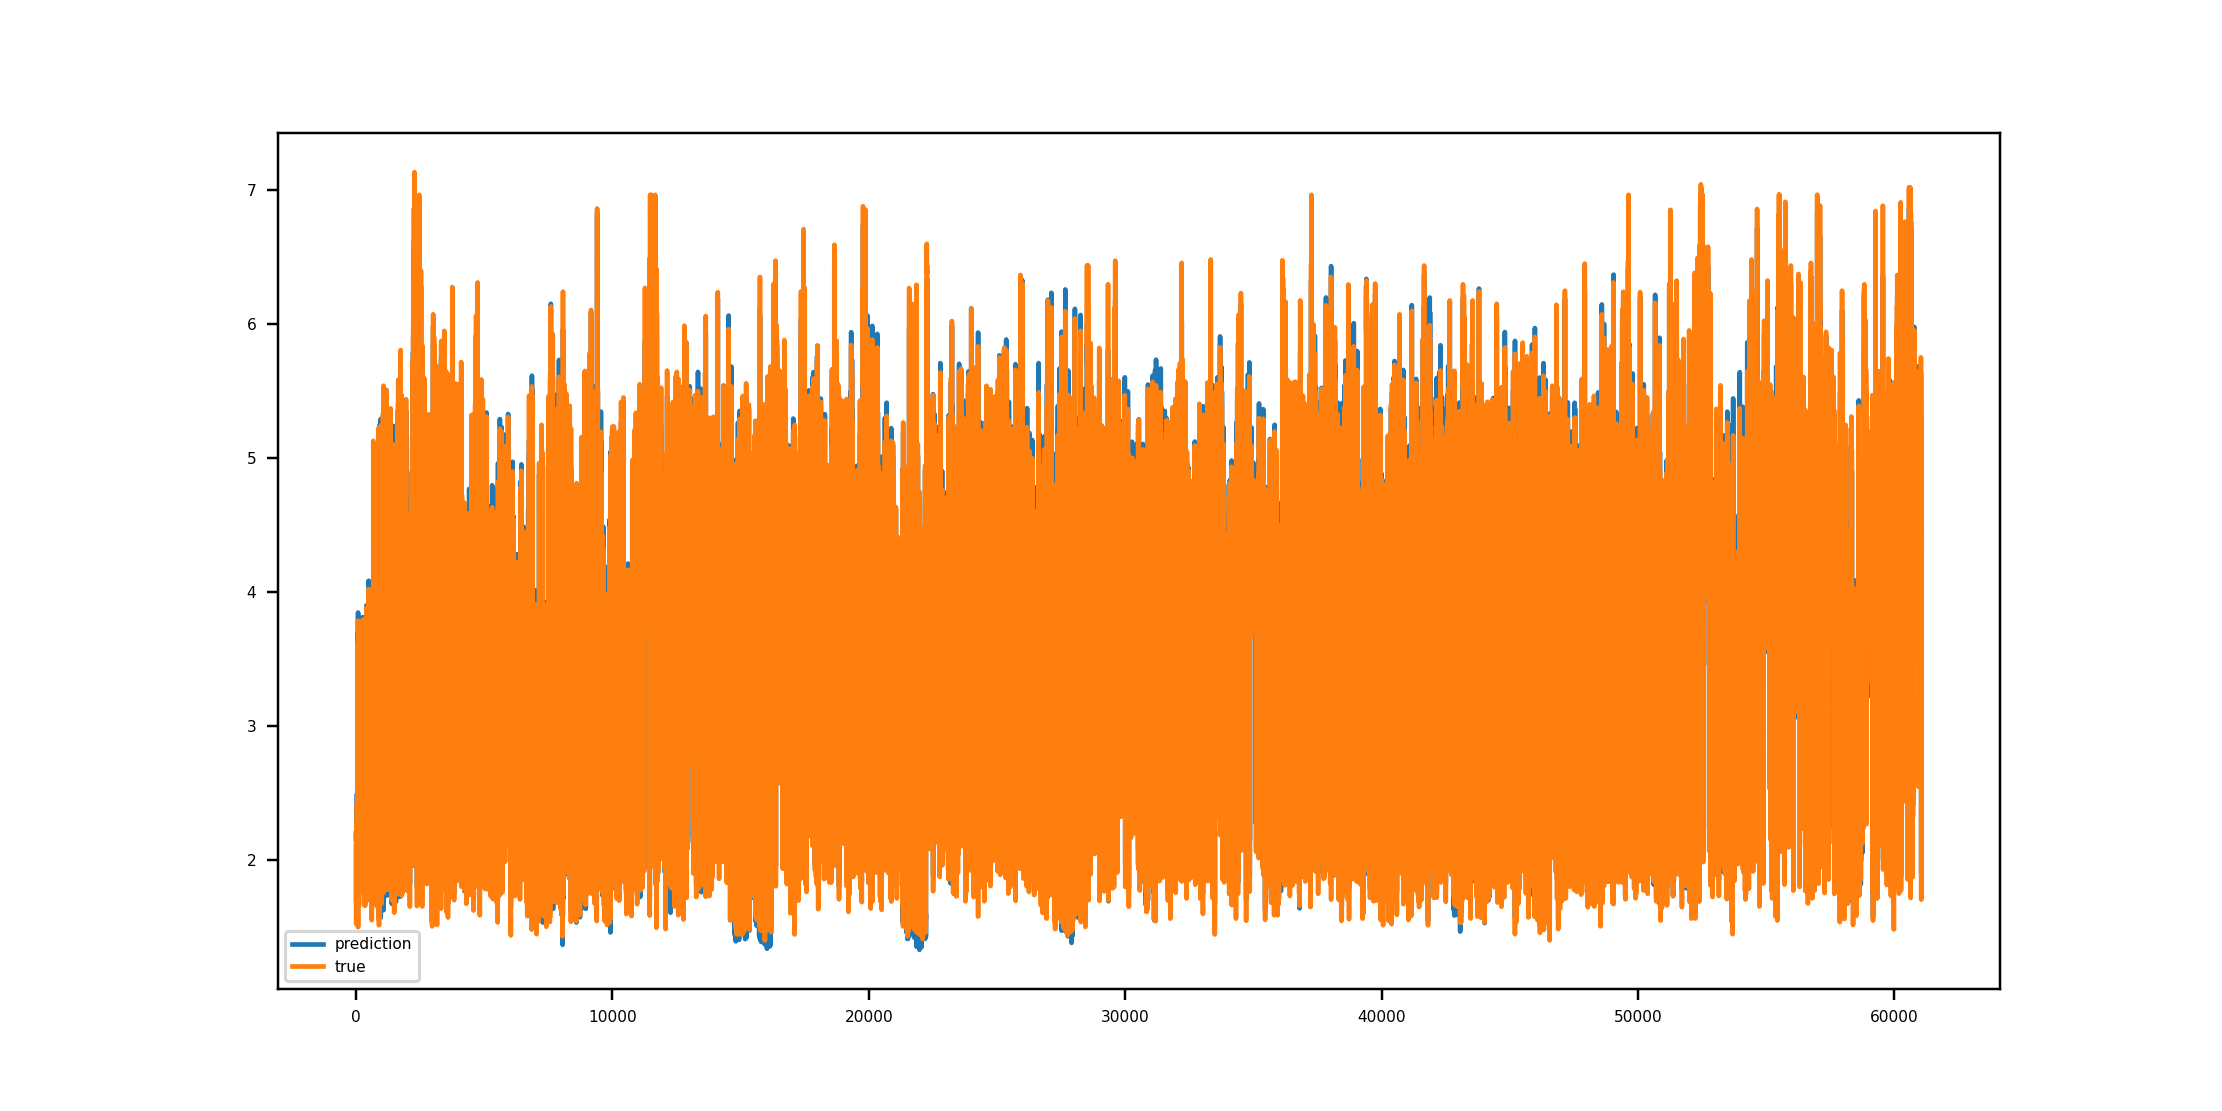

RMSE: 0.809
MAPE: 0.137
r2: 0.585


In [148]:
test = plot_history_acc(lstm_21_X_reshape, lstm_21_y, model)

In [149]:
test = test.astype('float64')


In [150]:
test

,test_predict,test_true,acc,mape
0,2.178231,2.098002,0.963168,0.038240
1,2.214311,2.048489,0.925113,0.080949
2,2.145659,2.048489,0.954713,0.047435
3,2.147590,2.048489,0.953855,0.048378
4,2.151150,2.048489,0.952276,0.050116
...,...,...,...,...
61065,4.505933,4.446065,0.986714,0.013465
61066,4.493305,4.446065,0.989487,0.010625
61067,4.454089,4.891126,1.098120,0.089353
61068,4.917116,4.340320,0.882696,0.132892


In [179]:
data = test[(test["mape"] >= 0.5) & (test["mape"] <= 1)]
test_high_acc = (data.shape[0]/test.shape[0])
test_high_acc

0.04959882102505322

In [180]:
data[0:50]

,test_predict,test_true,acc,mape
219,3.753046,2.058548,0.548501,0.823152
263,3.811667,2.110958,0.553815,0.805657
400,1.928297,3.880491,2.012393,0.503079
412,3.548851,1.810335,0.510118,0.960329
463,3.592685,1.928750,0.536855,0.862701
482,1.914484,3.880125,2.026721,0.506592
485,3.646437,1.868685,0.512469,0.951338
489,1.952555,4.021599,2.059659,0.514483
499,3.762076,1.899710,0.504963,0.980342
577,3.451535,1.871765,0.542299,0.844000


<IPython.core.display.Javascript object>


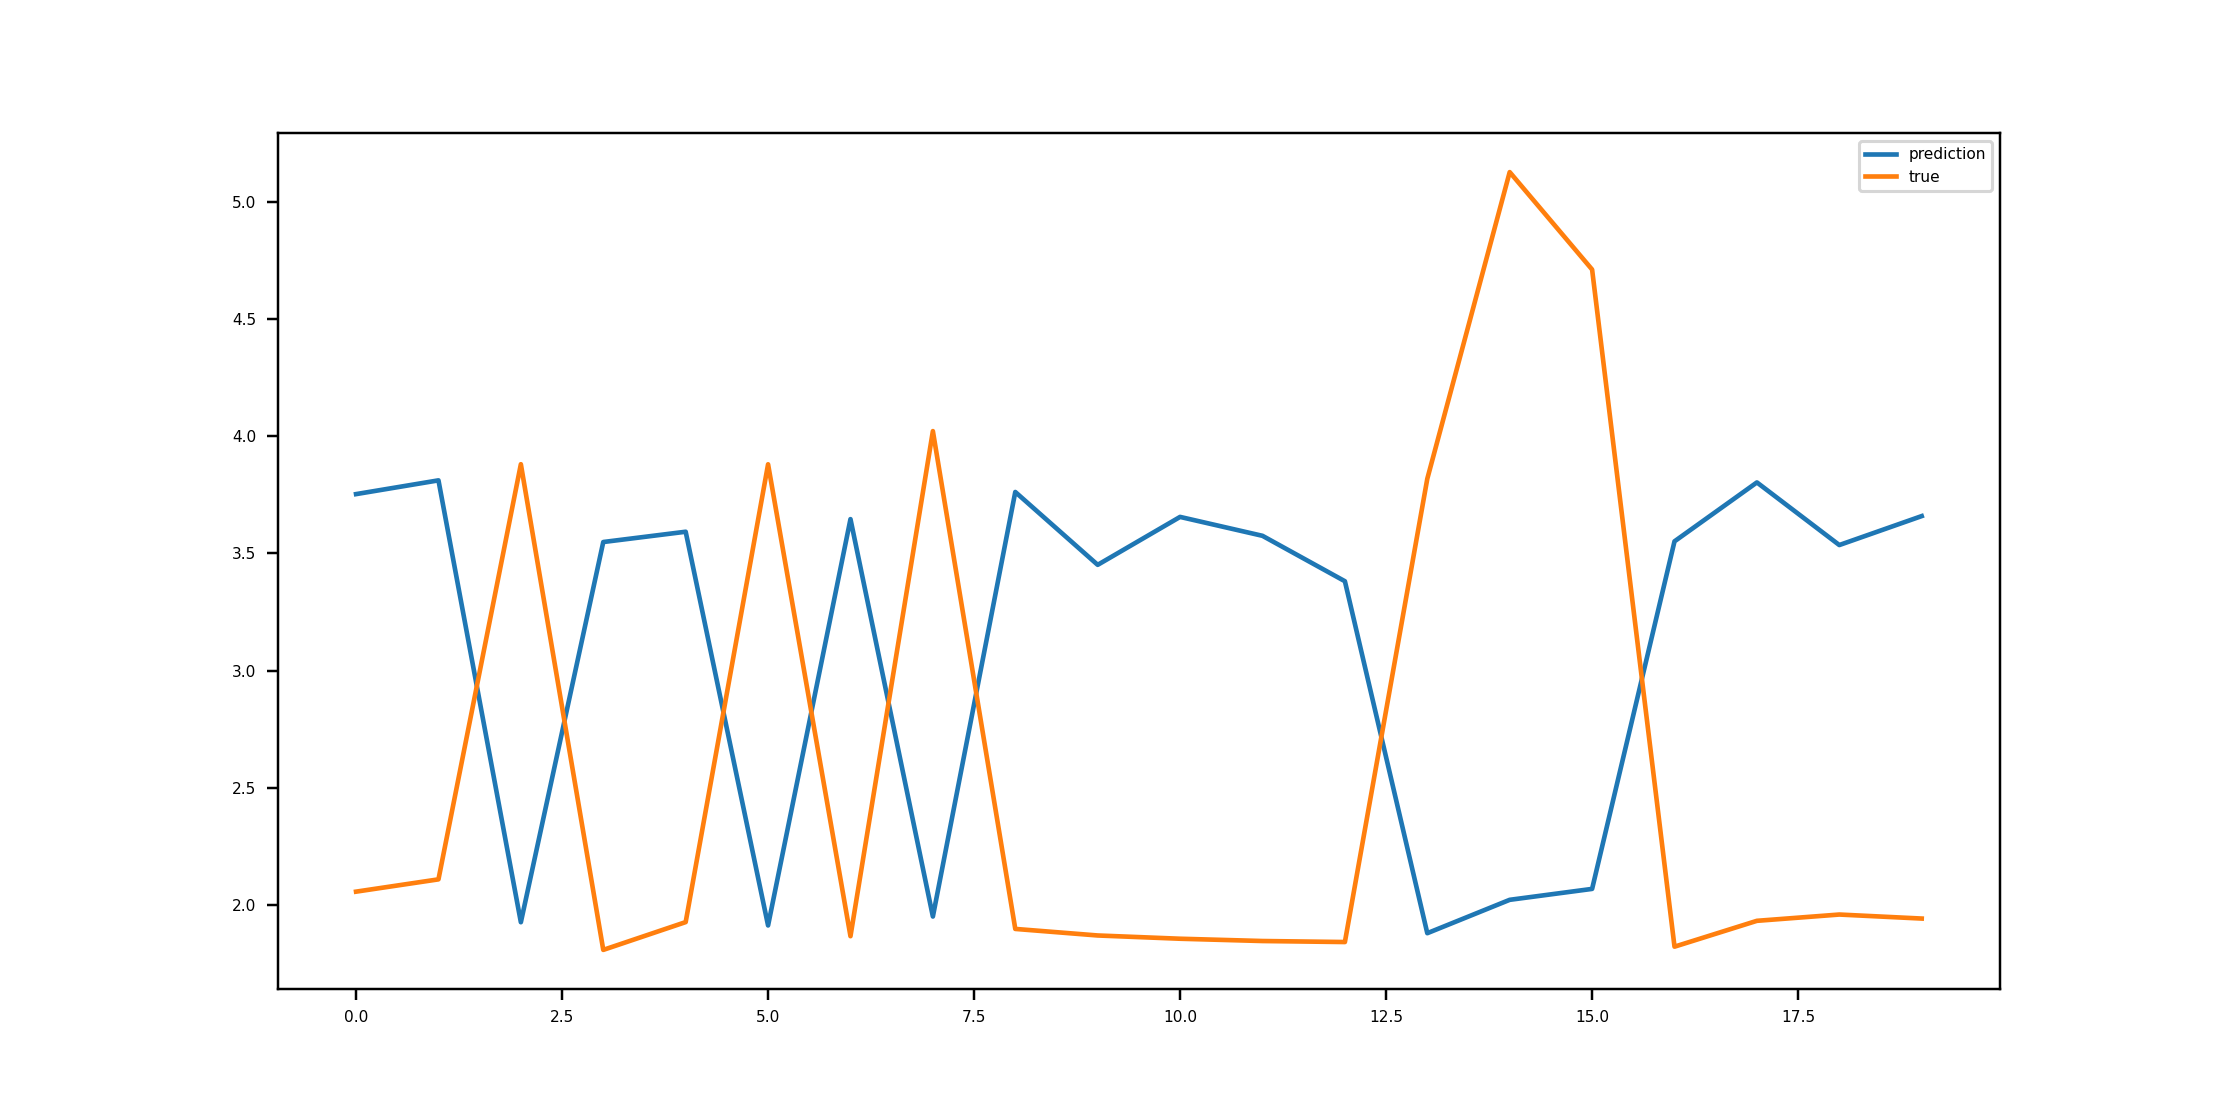

In [181]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data['test_predict'].values[0:20],label='prediction')
ax.plot(data['test_true'].values[0:20],label='true')
ax.legend()